Hermiticity check:
True


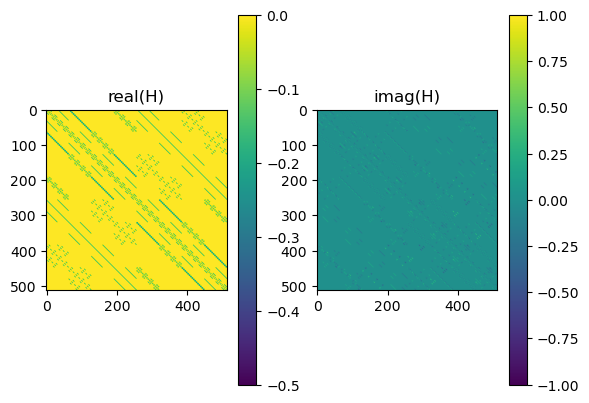

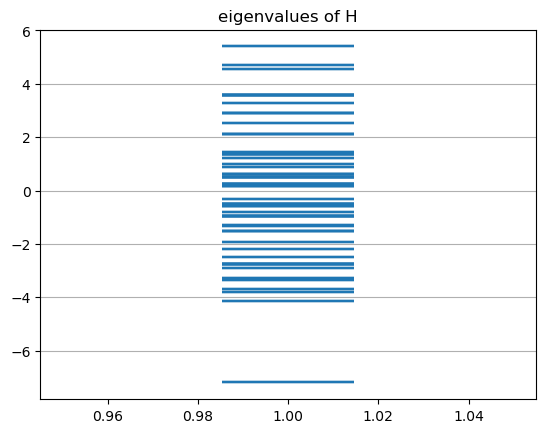

check that H Commutes with the 4 constraints:
True
True
True
True


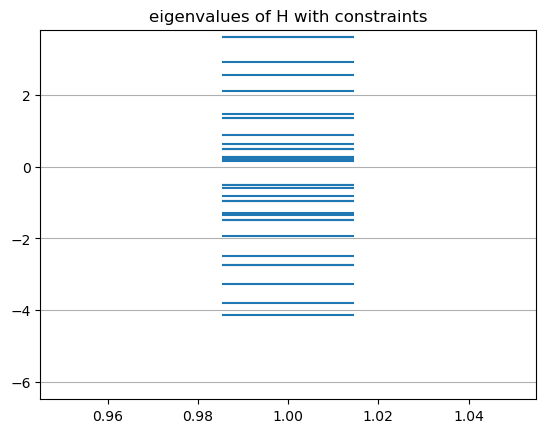

In [6]:
# D8 Hamiltonian for 4 sites in 1d
# here we also include boundary interaction terms and change some signs to work in the staggered case
# see notes version 4...


import numpy as np
import scipy
from numpy import ndarray
from quspin.basis import spin_basis_1d, tensor_basis, basis_int_to_python_int
from functools import reduce
import matplotlib as mpl
import D8_group_operators as go
# mpl.use('TkAgg')
import matplotlib.pyplot as plt
# configuration
L = 3   # numer of links
J = 1  # interaction strength
h = 1  # electric term strength (lambda_E in the notes)
M = 1  #mass


# define local qudit operations:
def local_X(level_indices, n_levels: int = 4):
    # pauli X on two levels
    mat = np.zeros([n_levels, n_levels], dtype=complex)
    mat[level_indices[0], level_indices[1]] = 1
    mat[level_indices[1], level_indices[0]] = 1
    return mat


def local_Y(level_indices, n_levels: int = 4):
    # pauli Y on two levels
    mat = np.zeros([n_levels, n_levels], dtype=complex)
    mat[level_indices[0], level_indices[1]] = -1j
    mat[level_indices[1], level_indices[0]] = 1j
    return mat


def local_Z(level_indices, n_levels: int = 4):
    # pauli z on two levels
    mat = np.zeros([n_levels, n_levels], dtype=complex)
    mat[level_indices[0], level_indices[0]] = 1
    mat[level_indices[1], level_indices[1]] = -1
    return mat


def local_P(level_indices, n_levels: int = 4):
    # projector to the subspace of two levels
    mat = np.zeros([n_levels, n_levels])
    mat[level_indices[0], level_indices[0]] = 1
    mat[level_indices[1], level_indices[1]] = 1
    return mat

def local_xx():
    return local_X([0,2])+local_X([1,3])

def local_xp():
    return local_X([0,2])+local_P([1,3])

def local_px():
    return local_X([1,3])+local_P([0,2])



# define QuSpin basis objects
basis_qubits = spin_basis_1d(L, S="1/2")
basis_qudits = spin_basis_1d(L, S="3/2")

basis_combined = tensor_basis(basis_qubits, basis_qudits)




# build global operations from local ones:
def single_site_op(local_op: ndarray, site: int, base: spin_basis_1d):
    """
    the tensor product of local_op on the site given by the variable site, and identity on all other sites.
    :param local_op: ndarray  - a matrix representation of a local operator
    :param site: int - site index
    :param base: quspin basis object
    :return: ndarray
    """
    if (site < 0) or (site > base.N - 1): # treat open BC
        return np.eye(base.Ns)
    else:
        local_dim = base.sps
        lattice_length = base.N
        # TODO: input verification: local_dim has to equal dim(local_op)
        local_op_lst = [np.eye(local_dim) for i in range(lattice_length)]
        local_op_lst[site] = local_op
        return reduce(np.kron, local_op_lst)



def X(site: int, level_indices=None):
    """
    returns a matrix corresponding to pauli X on one site between two levels given by level_indices. level indices
    are not supplied: this becomes an operation on the qubit register instead of the qudits. if site is outside the
    range, returns identify (this is helpful for boundary terms)
    """
    if level_indices is None:
        base = basis_qubits
        level_indices = [0, 1]
    else:
        base = basis_qudits
    #
    # if site < 0 or site > base.N - 1:
    #     return 0*np.eye(base.Ns)  # treat the boundary case
    # else:
    return single_site_op(local_X(level_indices, n_levels=base.sps), site, base)


def Y(site: int, level_indices=None):
    """
    returns a matrix corresponding to pauli Y on one site between two levels given by level_indices. level indices
    are not supplied: this becomes an operation on the qubit register instead of the qudits. if site is outside the
    range, returns identify (this is helpful for boundary terms)
    """
    if level_indices is None:
        base = basis_qubits
        level_indices = [0, 1]
    else:
        base = basis_qudits
    #
    # if site < 0 or site > base.N - 1:
    # #     return 0*np.eye(base.Ns)  # treat the boundary case
    # else:
    return single_site_op(local_Y(level_indices, n_levels=base.sps), site, base)


def Z(site: int, level_indices=None):
    """
    returns a matrix corresponding to pauli Z on one site between two levels given by level_indices. level indices
    are not supplied: this becomes an operation on the qubit register instead of the qudits. if site is outside the
    range, returns identify (this is helpful for boundary terms)
    """
    if level_indices is None:
        base = basis_qubits
        level_indices = [0, 1]
    else:
        base = basis_qudits
    #
    # if site < 0 or site > base.N - 1:
    #     return 0*np.eye(base.Ns)  # treat the boundary case
    # else:
    return single_site_op(local_Z(level_indices, n_levels=base.sps), site, base)


def P(site: int, level_indices=None):
    """
    returns a matrix corresponding to projector into two levels on one site between if site is outside the
    range, returns identify (this is helpful for boundary terms)
    """
    base = basis_qudits
    # if site < 0 or site > base.N - 1:
    #     return 0*np.eye(base.Ns)  # treat the boundary case
    # else:
    return single_site_op(local_P(level_indices, n_levels=base.sps), site, base)

def XX(site: int):
    base = basis_qudits
    return single_site_op(local_xx(), site, base)

def XP(site: int):
    base = basis_qudits
    return single_site_op(local_xp(), site, base)

def PX(site: int):
    base = basis_qudits
    return single_site_op(local_px(), site, base)

# %%
############################  build hamiltonian ######################################
# we build the qubit and qudit part separately.
# BEFORE we combine them (!), we have to flip the basis order in each of them, to agree with the QuSpin conventions
# this is easiest to do with a change-of-basis matrix:
U2 = np.fliplr(np.eye(basis_qubits.Ns))  # for the qubits
U4 = np.fliplr(np.eye(basis_qudits.Ns))  # for the qudits


# build electric hamiltonian:
def H_E(h, flip=True):
    H_E_qudits = np.zeros([basis_qudits.Ns, basis_qudits.Ns])
    for i in range(L):
        H_E_qudits = H_E_qudits - h / 2 * (X(i, [0, 2]) + X(i, [1, 3]))
    if flip:
        H_E_qudits = U4 @ H_E_qudits @ U4

    return np.kron(np.eye(basis_qubits.Ns), H_E_qudits)  # combine qudit part and qubit part


def sgn(site: int):
    # parity of the site (for staggered fermions)
    return (-1) ** site


# build the interaction part: it has 8 parts.
# keep them in two lists (for the qudit and qubit parts) and then combine them
def H_J_single_link(J, n: int, flip=True):
    """
    builds the interaction hamiltonian for one link specified by the integer n.
    :param J: interaction strength
    :param n: link index
    :param flip: flips the basis to agree with the QuSpin convention
    :return:
    """
    qubits_parts = []
    qudits_parts = []

    # comment on the signs: I use the expressions from before we added staggering, just add the appropriate signs
    # according to eqn. 7 in the theory document,
    H1_qubits = sgn(n + 1) * X(n) @ X(n + 1)
    H1_qudits = XX(n-1) @ Y(n, [0, 2]) @ XP(n+1)
    qubits_parts.append(H1_qubits)
    qudits_parts.append(H1_qudits)

    H2_qubits = -sgn(n) * X(n - 1) @ X(n)
    H2_qudits = Y(n, [0, 2])
    qubits_parts.append(H2_qubits)
    qudits_parts.append(H2_qudits)

    H3_qubits = -Z(n)
    H3_qudits = XX(n-1) @ Y(n, [1, 3]) @ XX(n+1)
    qubits_parts.append(H3_qubits)
    qudits_parts.append(H3_qudits)

    H4_qubits = -X(n - 1) @ Z(n) @ X(n + 1)
    H4_qudits = Y(n, [1, 3]) @ XP(n+1)
    qubits_parts.append(H4_qubits)
    qudits_parts.append(H4_qudits)

    H5_qubits = -np.eye(basis_qubits.Ns)
    H5_qudits = Y(n, [1, 3])
    qubits_parts.append(H5_qubits)
    qudits_parts.append(H5_qudits)

    H6_qubits = -X(n - 1) @ X(n + 1)
    H6_qudits = Y(n, [1, 3]) @ XP(n+1)
    qubits_parts.append(H6_qubits)
    qudits_parts.append(H6_qudits)

    H7_qubits = sgn(n) * X(n - 1) @ Y(n)
    H7_qudits = Z(n, [0, 2]) @ XX(n+1)
    qubits_parts.append(H7_qubits)
    qudits_parts.append(H7_qudits)

    H8_qubits = -sgn(n + 1) * Y(n) @ X(n + 1)
    H8_qudits = Z(n, [0, 2]) @ XP(n+1)
    qubits_parts.append(H8_qubits)
    qudits_parts.append(H8_qudits)

    full_H_J_single_site = np.zeros([basis_qubits.Ns * basis_qudits.Ns, basis_qubits.Ns * basis_qudits.Ns])
    for i in range(8):
        if flip:
            H_qubits = U2 @ qubits_parts[i] @ U2
            H_qudits = U4 @ qudits_parts[i] @ U4
        else:
            H_qubits = qubits_parts[i]
            H_qudits = qudits_parts[i]

        full_H_J_single_site = full_H_J_single_site + J / 2 * np.kron(H_qubits, H_qudits)

    return full_H_J_single_site


#full interaction hamiltonian:
def H_J(J, flip=True):
    full_H_J = np.zeros([basis_qubits.Ns * basis_qudits.Ns, basis_qubits.Ns * basis_qudits.Ns])
    for link in range(L):
        full_H_J = full_H_J + H_J_single_link(J, link, flip)
    return full_H_J




#build mass hamiltonian:
#left = 0, center = 1 and right = 2
I_qudits = np.eye(basis_qudits.Ns)
I_qubits = np.eye(basis_qubits.Ns)
def H_M(M, flip=True):
    qubits_parts = []
    qudits_parts = []

    H_M_qubits0 = X(0)
    H_M_qudits0 = XP(0)
    qubits_parts.append(H_M_qubits0)
    qudits_parts.append(H_M_qudits0)

    H_M_qubits1 = X(0)
    H_M_qudits1 = PX(0)
    qubits_parts.append(H_M_qubits1)
    qudits_parts.append(H_M_qudits1)

    H_M_qubits2 = X(0)@X(1)
    H_M_qudits2 = XX(0)@XP(1)
    qubits_parts.append(H_M_qubits2)
    qudits_parts.append(H_M_qudits2)

    H_M_qubits3 = X(0)@X(1)
    H_M_qudits3 = I_qudits@PX(1)
    qubits_parts.append(H_M_qubits3)
    qudits_parts.append(H_M_qudits3)

    H_M_qubits4 = X(1)@X(2)
    H_M_qudits4 = XX(1)@XP(2)
    qubits_parts.append(H_M_qubits4)
    qudits_parts.append(H_M_qudits4)

    H_M_qubits5 = X(1)@X(2)
    H_M_qudits5 = I_qudits@PX(2)
    qubits_parts.append(H_M_qubits5)
    qudits_parts.append(H_M_qudits5)

    H_M_qubits6 = X(2)
    H_M_qudits6 = XX(2)
    qubits_parts.append(H_M_qubits6)
    qudits_parts.append(H_M_qudits6)

    H_M_qubits7 = X(2)
    H_M_qudits7 = I_qudits
    qubits_parts.append(H_M_qubits7)
    qudits_parts.append(H_M_qudits7)

    full_HM = np.zeros([basis_qubits.Ns * basis_qudits.Ns, basis_qubits.Ns * basis_qudits.Ns])
    for i in range(8):
        if flip:
            H_qubits = U2 @ qubits_parts[i] @ U2
            H_qudits = U4 @ qudits_parts[i] @ U4
        else:
            H_qubits = qubits_parts[i]
            H_qudits = qudits_parts[i]

        full_HM = full_HM - M / 2 * np.kron(H_qubits, H_qudits)

    return full_HM


# full Hamiltonian:
H = H_E(h, True) + H_J(J , flip=True) + H_M(M, flip=True)
# H = H_E(0, True) + H_J_single_link(J,1)
# check hermiticity
print("Hermiticity check:")
print(scipy.linalg.ishermitian(H))

# plot hamiltonian
fig, axs = plt.subplots(1, 2)
p1 = axs[0].imshow(np.real(H))
p2 = axs[1].imshow(np.imag(H))
fig.colorbar(p1)
fig.colorbar(p2)

axs[0].title.set_text('real(H)')
axs[1].title.set_text('imag(H)')
plt.show()
# plot spectrum
levels = np.linalg.eigvals(H)
x = np.ones(np.size(levels))
# x = np.arange(len(levels))
levels = np.sort(levels)
plt.figure()

plt.scatter(x, np.real(levels), marker="_", s=9000)
plt.grid(axis='y')
plt.title("eigenvalues of H")
plt.show()

# %% check that H commutes with the constraints:
import D8_constraints_1D as cr
print("check that H Commutes with the 4 constraints:")
print(not (abs(H@cr.G0 - cr.G0@H).any()))
print(not (abs(H@cr.G1 - cr.G1@H).any()))
print(not (abs(H@cr.G2 - cr.G2@H).any()))
print(not (abs(H@cr.G3 - cr.G3@H).any()))

# %% add the constraints as penalty

lam = 10
I = np.eye(basis_combined.Ns)
H = H + lam*((cr.G0-I)@(cr.G0-I)+(cr.G1-I)@(cr.G1-I) + (cr.G2-I)@(cr.G2-I) + (cr.G3-I)@(cr.G3-I) )
levels = np.linalg.eigvals(H)
x = np.ones(np.size(levels))

levels = np.sort(levels)

plt.scatter(x, np.real(levels), marker="_", s=9000)
plt.grid(axis='y')
plt.title("eigenvalues of H with constraints")

# focus on the low energy sector
plt.ylim([np.min(levels)-0.1*np.min(levels),np.min(levels)+1.1*lam])

plt.show()